In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import time
from torch.utils.tensorboard import SummaryWriter

In [2]:
current_time = time.strftime("%Y_%m_%d-%H_%M_%S", time.localtime())
writer_folder_path = 'runs/koph/ass_3/'+current_time
writer_run_counter = 0
writer = SummaryWriter(writer_folder_path)

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


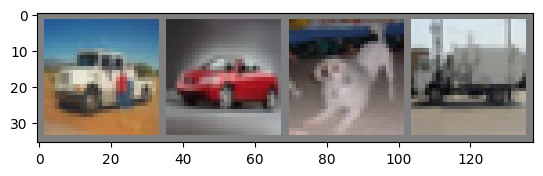

truck car   dog   truck


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [5]:
writer.add_image('four_cifar_images', torchvision.utils.make_grid(images))

In [6]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 3)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.conv4 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 5 * 5, 4096)
        self.fc2 = nn.Linear(4096, 1000)
        self.fc3 = nn.Linear(1000, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv2(F.relu(self.conv1(x)))))
        x = self.pool(F.relu(self.conv4(F.relu(self.conv3(x)))))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
device = torch.device('cpu')

In [8]:
def train(epoch):
    global writer_run_counter
    # run_writer = SummaryWriter(writer_folder_path+"/run"+time.strftime("%Y_%m_%d-%H_%M_%S", time.localtime()))
    run_writer = SummaryWriter(f'{writer_folder_path}/run{writer_run_counter}')
    
    for epoch in range(epoch):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                
                run_writer.add_scalar('train/loss',
                            running_loss / 2000,
                            epoch * len(trainloader) + i)
                
                running_loss = 0.0

    print('Finished Training')
    writer_run_counter = writer_run_counter + 1

In [9]:
def test():
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

In [70]:
def test_topk(topk=3):
    false_images = []
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.topk(outputs, topk)
            
            mask = [l in p for l, p in zip(labels, predicted)]
            mask = np.array(mask)
            if any(value == False for value in mask):
                false_images.append([[im, l] for im, l, mask in zip(images, labels, mask) if not mask])
            #false_images_labels.append(labels[~mask])
                        
            total += labels.size(0)
            correct += sum(mask)

    accuracy = 100 * correct // total
    print(f'Accuracy of the network on the 10000 test images: {accuracy} %')

    return accuracy, false_images

In [53]:
start_time = time.time()
train(2)
end_time = time.time()
cpu_time = end_time - start_time
test()

[1,  2000] loss: 2.299
[1,  4000] loss: 2.074
[1,  6000] loss: 1.847
[1,  8000] loss: 1.660
[1, 10000] loss: 1.566
[1, 12000] loss: 1.493
[2,  2000] loss: 1.361
[2,  4000] loss: 1.346
[2,  6000] loss: 1.312
[2,  8000] loss: 1.241
[2, 10000] loss: 1.190
[2, 12000] loss: 1.151
Finished Training
Accuracy of the network on the 10000 test images: 59 %


In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


In [12]:
net = Net()
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [13]:
#writer_run_counter = writer_run_counter + 1

In [16]:
start_time = time.time()
train(2)
end_time = time.time()
gpu_time = end_time - start_time
test()

#print("CPU Time", cpu_time)
print("GPU Time", gpu_time)

[1,  2000] loss: 2.303
[1,  4000] loss: 2.174
[1,  6000] loss: 1.882
[1,  8000] loss: 1.730
[1, 10000] loss: 1.629
[1, 12000] loss: 1.579
[2,  2000] loss: 1.476
[2,  4000] loss: 1.420
[2,  6000] loss: 1.360
[2,  8000] loss: 1.291
[2, 10000] loss: 1.242
[2, 12000] loss: 1.200
Finished Training
Accuracy of the network on the 10000 test images: 56 %
GPU Time 549.8664920330048


In [58]:
gpu_time

447.81878900527954

In [71]:
_, false_images = test_topk()

Accuracy of the network on the 10000 test images: 86 %


In [75]:
import random
number_of_images = 5
random_images = random.sample(false_images, number_of_images)

fig = plt.figure()
for i, data in enumerate(random_images):
    img, label = data[0]
    img = img.cpu()
    plt.subplot(1, number_of_images, i + 1)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.title(classes[label])

writer.add_figure("False Images", fig)

In [13]:
from tensorboard import notebook
%load_ext tensorboard
%tensorboard --logdir runs
notebook.list()

Reusing TensorBoard on port 6007 (pid 12356), started 0:13:02 ago. (Use '!kill 12356' to kill it.)

Known TensorBoard instances:
  - port 6007: logdir runs (started 0:13:02 ago; pid 12356)
  - port 6006: logdir run (started 0:13:09 ago; pid 13020)


In [15]:
notebook.display(port=6006, height=1000)